In [1]:
%load_ext autoreload
%autoreload 2

import datetime
import numpy as np
import scipy as sp
import pandas as pd
import functools as fts
import multiprocessing as mp
from tqdm.notebook import tqdm
from tqdm.contrib import tzip, tenumerate, tmap

from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.storagelevel import StorageLevel
from pyspark.sql.functions import col
import pyspark.sql.types as pstype
import pyspark.sql.functions as F
import pyspark as ps

import matplotlib as mlt
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML
import japanize_matplotlib

from time_series_model import *

%matplotlib inline
%matplotlib ipympl

In [2]:
ps_conf = ps.SparkConf().set("spark.logConf", "false")\
            .set("spark.executor.memory", "12g")\
            .set("spark.driver.memory", "4g")\
            .set("spark.executor.cores", "7")\
            .set("spark.sql.shuffle.partitions", "500")\
            .set("spark.executor.extraJavaOptions", "-XX:+UseG1GC -XX:+UseStringDeduplication")\
            .set("spark.eventLog.gcMetrics.youngGenerationGarbageCollectors", "G1 Young Generation")\
            .set("spark.eventLog.gcMetrics.oldGenerationGarbageCollectors", "G1 Old Generation")\
			.set("spark.logConf", "false")
spark = SparkSession.builder.config(conf=ps_conf).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/11 14:58:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/11 14:58:06 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
SPECIFIED_PATH = "csv_data/"
SPECIFIED_DATE = "20240918"
SPECIFIED_CSV  = SPECIFIED_PATH + SPECIFIED_DATE

In [4]:
input_path = SPECIFIED_CSV + "_c-united_config.csv"
df_config  = spark.read.option("inferSchema", "True").option("header", "True").csv(input_path)
df_config.persist(StorageLevel.MEMORY_AND_DISK_DESER)

utid_list = df_config.select("unit_id").drop_duplicates().rdd.flatMap(lambda x: x).collect()
spid_list = df_config.select("shop_id").drop_duplicates().rdd.flatMap(lambda x: x).collect()

In [5]:
#pos data 前処理
input_path  = SPECIFIED_CSV + "_pos_data_table.csv"
df_pos_data = spark.read.option('inferSchema', 'True').option('header', 'True').csv(input_path)\
				.select(
					"shop_id",
                    "レシートＮｏ．",
                    "商品種別",
                    "商品コード",
                    F.regexp_replace(col("商品名称（または券名称）"), "[ 　]", "").alias("商品名称（または券名称）"),
                    "オーダー時刻",
                    "単価",
                    "数量",
                    "合計金額",
                    "date"
				)\
				.filter(col("商品名称（または券名称）") != "")\
				.groupBy("shop_id", "date", "レシートＮｏ．").agg(
                    F.last("オーダー時刻").alias("オーダー時刻"),
                    F.sum(F.when(col("商品種別") == "Y", 1).otherwise(0)).alias("レシートあたりのセット商品の数"),
                    F.sum("数量").alias("総売上点数"),
                    F.sum("合計金額").alias("総売上"),
				)\
                .withColumn("レシートあたりのセット商品の数", F.when(col("レシートあたりのセット商品の数") == 0, 1)
                            								.otherwise(col("レシートあたりのセット商品の数")))\
                .withColumn("オーダー時刻", (F.col("オーダー時刻") / 100).cast("int"))\
                .withColumnRenamed("レシートあたりのセット商品の数", "来店者数")\
                .withColumnRenamed("オーダー時刻", "hour")
df_pos_data = df_pos_data.groupBy("shop_id", "date", "hour").agg(
                    F.sum("来店者数").alias("来店者数"),
                    F.sum("総売上点数").alias("総売上点数"),
                    F.sum("総売上").alias("総売上"),
				)\
                .select(["shop_id", "date", "hour", "来店者数", "総売上点数", "総売上"])\
                .orderBy(col("shop_id").asc(), col("date").asc(), col("hour").asc())
df_pos_data.show()


+-------+----------+----+--------+----------+------+
|shop_id|      date|hour|来店者数|総売上点数|総売上|
+-------+----------+----+--------+----------+------+
|   1189|2023-10-10|   6|       1|         1|   360|
|   1189|2023-10-10|   7|      56|        98| 43340|
|   1189|2023-10-10|   8|      50|        84| 36170|
|   1189|2023-10-10|   9|      66|       404|156520|
|   1189|2023-10-10|  10|      62|       129| 57640|
|   1189|2023-10-10|  11|      52|       120| 66465|
|   1189|2023-10-10|  12|     107|       206| 99340|
|   1189|2023-10-10|  13|      97|       166| 76190|
|   1189|2023-10-10|  14|      92|       185| 90990|
|   1189|2023-10-10|  15|     102|       176| 77170|
|   1189|2023-10-10|  16|     102|       204| 90260|
|   1189|2023-10-10|  17|      69|       174| 80205|
|   1189|2023-10-10|  18|      77|       125| 60590|
|   1189|2023-10-10|  19|      67|       133| 61540|
|   1189|2023-10-10|  20|      41|        74| 34710|
|   1189|2023-10-10|  21|      13|        26| 11895|
|   1

In [6]:
df_pos_data = df_pos_data\
    				.withColumn("date", F.from_unixtime(F.unix_timestamp("date") + F.col("hour") * 3600))\
                    .drop("hour")\
                    .orderBy(col("shop_id").asc(), col("date").asc())
df_pos_data.show()

24/10/11 14:58:18 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-------+-------------------+--------+----------+------+
|shop_id|               date|来店者数|総売上点数|総売上|
+-------+-------------------+--------+----------+------+
|   1189|2023-10-10 06:00:00|       1|         1|   360|
|   1189|2023-10-10 07:00:00|      56|        98| 43340|
|   1189|2023-10-10 08:00:00|      50|        84| 36170|
|   1189|2023-10-10 09:00:00|      66|       404|156520|
|   1189|2023-10-10 10:00:00|      62|       129| 57640|
|   1189|2023-10-10 11:00:00|      52|       120| 66465|
|   1189|2023-10-10 12:00:00|     107|       206| 99340|
|   1189|2023-10-10 13:00:00|      97|       166| 76190|
|   1189|2023-10-10 14:00:00|      92|       185| 90990|
|   1189|2023-10-10 15:00:00|     102|       176| 77170|
|   1189|2023-10-10 16:00:00|     102|       204| 90260|
|   1189|2023-10-10 17:00:00|      69|       174| 80205|
|   1189|2023-10-10 18:00:00|      77|       125| 60590|
|   1189|2023-10-10 19:00:00|      67|       133| 61540|
|   1189|2023-10-10 20:00:00|      41|     

In [7]:
df_pos_data = df_pos_data\
					.join(df_config.select(["shop_id", "caption"]), on="shop_id", how="inner")\
                    .select(["shop_id", "caption", "date", "来店者数", "総売上点数", "総売上"])\
                    .orderBy(col("shop_id").asc(), col("date").asc())
df_pos_data.show()

+-------+-------------------------------------+-------------------+--------+----------+------+
|shop_id|                              caption|               date|来店者数|総売上点数|総売上|
+-------+-------------------------------------+-------------------+--------+----------+------+
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 06:00:00|       1|         1|   360|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 07:00:00|      56|        98| 43340|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 08:00:00|      50|        84| 36170|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 09:00:00|      66|       404|156520|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 10:00:00|      62|       129| 57640|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 11:00:00|      52|       120| 66465|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 12:00:00|     107|       206| 99340|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 13:00:00|      97|       166| 76190|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 14:00:00|      92|       185| 90990|
|   1189|カフェ・ド・クリエグランサンシャ

In [8]:
pd_pos_data = df_pos_data.select(["shop_id", "caption", "date", "来店者数"]).toPandas()
pd_pos_data = pd_pos_data[pd_pos_data["shop_id"] == 1189]
pd_pos_data

,shop_id,caption,date,来店者数
0,1189,カフェ・ド・クリエグランサンシャイン通り店,2023-10-10 06:00:00,1
1,1189,カフェ・ド・クリエグランサンシャイン通り店,2023-10-10 07:00:00,56
2,1189,カフェ・ド・クリエグランサンシャイン通り店,2023-10-10 08:00:00,50
3,1189,カフェ・ド・クリエグランサンシャイン通り店,2023-10-10 09:00:00,66
4,1189,カフェ・ド・クリエグランサンシャイン通り店,2023-10-10 10:00:00,62
...,...,...,...,...
5355,1189,カフェ・ド・クリエグランサンシャイン通り店,2024-09-15 17:00:00,129
5356,1189,カフェ・ド・クリエグランサンシャイン通り店,2024-09-15 18:00:00,87
5357,1189,カフェ・ド・クリエグランサンシャイン通り店,2024-09-15 19:00:00,73
5358,1189,カフェ・ド・クリエグランサンシャイン通り店,2024-09-15 20:00:00,75


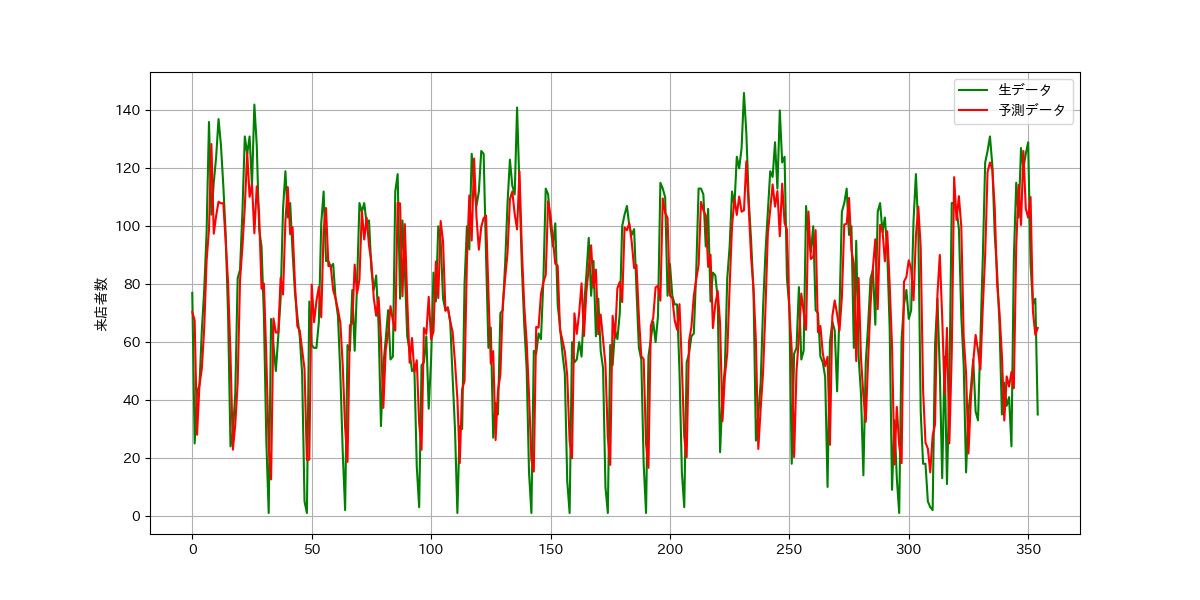

In [11]:
model = Auto_Regressive()
x_data = pd_pos_data["来店者数"].values.tolist()
x_train, x_test = x_data[0:5000], x_data[5000:]
lag = 5
model.fit(x_test, lags=lag)

num = len(x_test)
mean = []
for idx in range(lag, num):
	test_data = []
	for idx2 in range(0, lag):
		test_data.append(x_test[idx - idx2 - 1])
	tmp = model.predict([test_data])
	mean.append(tmp)

plt.figure(figsize=(12, 6))
plt.plot(x_test[lag:], "-", color="green", label="生データ")
plt.plot(mean,         "-", color="red",   label="予測データ")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

In [12]:
print(model.stat_inf())
print(model.log_likelihood(x_test))
print(model.model_reliability(x_test, ic="aic"))
print(model.model_reliability(x_test, ic="bic"))
print(model.model_reliability(x_test, ic="hqic"))

{'mean': np.float64(73.55886255437572), 'variance': np.float64(1396.1025200033262), 'standard deviation': np.float64(37.364455301841694)}
-1582.9379078349912
3179.8758156699823
3206.98064019631
3190.6588305787545


AR model | hqic
AR(1) | 3252.3953066811246
AR(2) | 3239.657616807019
AR(3) | 3226.9126895486756
AR(4) | 3214.5834952193404
AR(5) | 3190.6588305787545
AR(6) | 3170.733818241473
AR(7) | 3162.7481537519375
AR(8) | 3154.4305701532103
AR(9) | 3150.020941349125
AR(10) | 3135.669944158236
AR(11) | 3115.4139062504632
AR(12) | 3106.7814937274215
AR(13) | 3092.5948493297597
AR(14) | 3071.7392154830627
AR(15) | 3040.738826714184
AR(16) | 3036.0133834464923
AR(17) | 3013.5825777481077
selected orders | 17


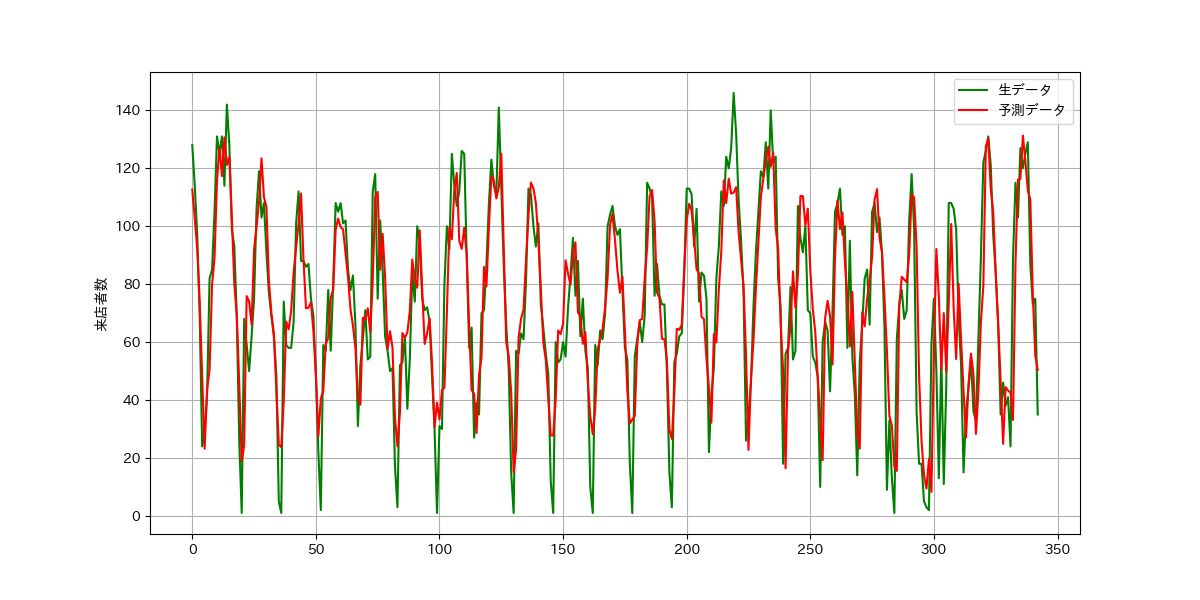

In [13]:
lag = model.select_order(x_test, maxlag=17, ic="hqic", isVisible=True)

num = len(x_test)
mean = []
for idx in range(lag, num):
	test_data = []
	for idx2 in range(0, lag):
		test_data.append(x_test[idx - idx2 - 1])
	tmp = model.predict([test_data])
	mean.append(tmp)

plt.figure(figsize=(12, 6))
plt.plot(x_test[lag:], "-", color="green", label="生データ")
plt.plot(mean,         "-", color="red",   label="予測データ")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

{'mean': np.float64(72.5993587006145), 'variance': np.float64(650.0493092333971), 'standard deviation': np.float64(25.49606458325279)}


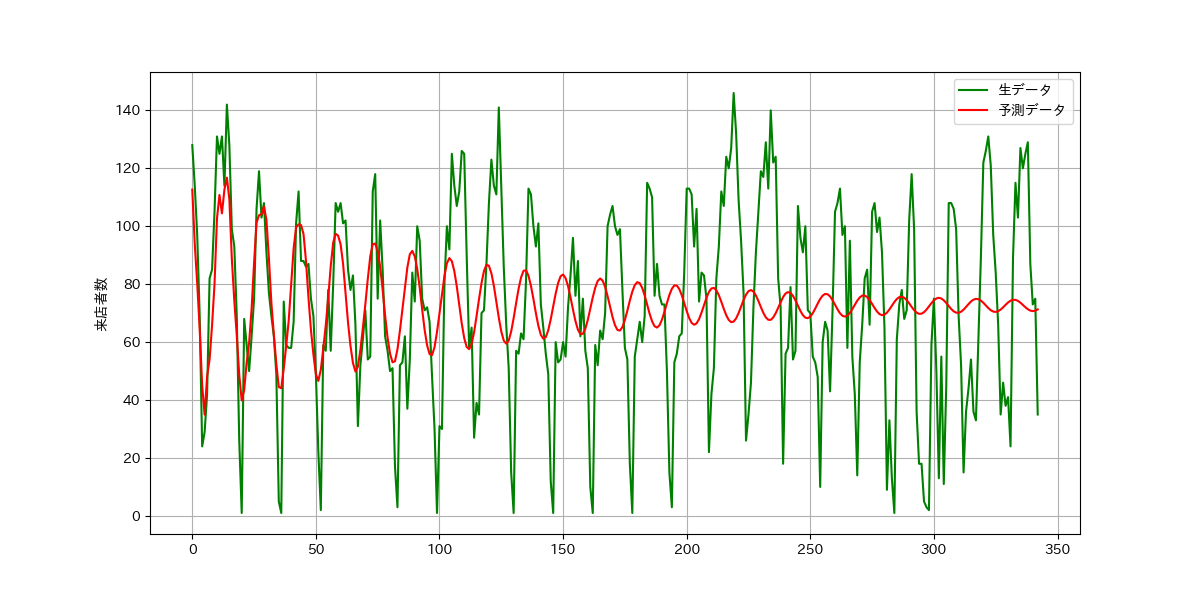

In [14]:
num = len(x_test)
mean = []
test_data = []
for idx in range(0, lag):
	test_data.append(x_test[lag - idx - 1])
for idx in range(lag, num):
	tmp = model.predict([test_data])
	mean.append(tmp)
	test_data = [*tmp, *test_data[0:-1]]

plt.figure(figsize=(12, 6))
plt.plot(x_test[lag:], "-", color="green", label="生データ")
plt.plot(mean,         "-", color="red",   label="予測データ")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

print(model.stat_inf())